## Environment bootstrap

We pin the working directory to the project root and expose the `src/` package
on `sys.path`. This makes imports stable no matter where the notebook is opened.

- **Python:** shown should be the `.venv` interpreter.
- **CWD:** should be the `FreqTransfer` folder.


In [2]:
# bootstrap (put this cell first in all notebooks)
import os, sys
PROJECT_ROOT = r"C:\Users\31624\Documents\MIT\Programming\FreqTransfer"
os.chdir(PROJECT_ROOT)
if PROJECT_ROOT not in sys.path: sys.path.insert(0, PROJECT_ROOT)
print("Python:", sys.executable); print("CWD:", os.getcwd())


Python: c:\Users\31624\Documents\MIT\Programming\FreqTransfer\.venv\Scripts\python.exe
CWD: C:\Users\31624\Documents\MIT\Programming\FreqTransfer


## What we import (one-liner overview)

- **Config & types:** `GridSpec`, `FDConfig`, `PMLConfig`, `SolverOptions`
- **Loads (RHS):** `PointSource`, `RandomPointSource`, `PlaneWave`, `build_load`
- **Operators:** `assemble_operator` (Helmholtz/Laplacian, optional PML)
- **Solvers:** `gmres_solve` (iterative) and `direct_solve` (sparse LU)
- **Utils:** plotting helpers and sweep utilities


In [9]:
from src import (
    GridSpec, FDConfig, PMLConfig, SolverOptions,
    assemble_operator, PointSource, RandomPointSource, PlaneWave, build_load,
    gmres_solve, direct_solve, plot_field, plot_residuals,
    sweep_k, sweep_sources, save_field
)
import numpy as np

## Experiment settings

- **Grid:** \((60 \times 60)\) on a \(1\times 1\) domain → uniform spacing.
- **Wavenumber \(k\):** controls wavelength and interference pattern.
- **PML:** optional absorbing layer near boundaries (`pml=None` to disable).
- **Source:** choose **point**, **plane wave**, or **random point**.
- **Solver:** toggle `gmres` (iterative) or `direct` (LU).
- **GMRES options:** `tol=1e-6`, `restart=200` — lower `tol` → more iterations.

Set these here once; all cells below use the same setup.


In [ ]:


grid = GridSpec(2, (60,60), (1.0,1.0))
k = 30.0
use_pml = False
pml = PMLConfig(thickness=8, m=3, sigma_max=50.0) if use_pml else None
rhs_spec = RandomPointSource(seed=42)       # swap for PointSource/PlaneWave
solver   = "direct"                          # "gmres" or "direct"
gmres_opts = SolverOptions(tol=1e-6, restart=200)


## Single run: assemble → load → solve → plot

1. Build the Helmholtz matrix \(A(k)\) (optionally with PML).
2. Build the RHS \(b\) from the chosen source.
3. Solve \(A u = b\).
   - If **GMRES**, we plot the residual history toward `tol`.
   - If **direct**, we skip residuals (LU is non-iterative).
4. Plot the field **magnitude** \(|u|\).  
   Bright regions indicate higher amplitude near sources and constructive
   interference; darker regions reflect decay/destructive interference or
   absorption (if PML is on).


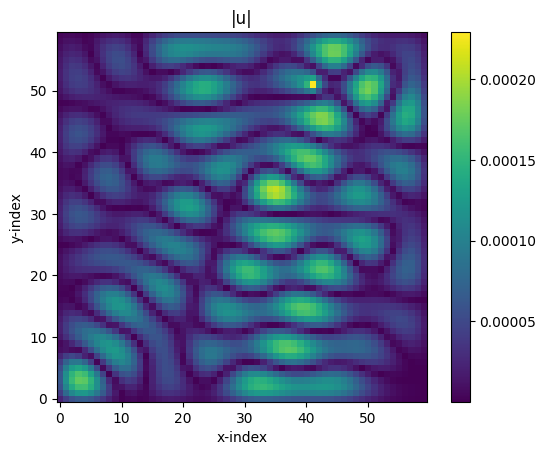

In [4]:
A = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=pml)
b = build_load(rhs_spec, grid)

if solver == "gmres":
    res = gmres_solve(A, b, options=gmres_opts); _ = plot_residuals(res, tol=gmres_opts.tol)
else:
    res = direct_solve(A, b)

_ = plot_field(res.solution, grid.shape, "magnitude")
# save_field("data/results/02/field_u.npz", res.solution, grid.shape)


## Direct vs GMRES 

- **Direct (LU):** great reference for small/medium problems; gives the solution
  in one shot but can become memory-heavy on large grids.
- **GMRES:** iterative; converges toward the LU solution. Useful to study
  convergence behavior and scale to bigger systems.

**Reading the output:**
- `Direct ok: True` confirms the baseline solution exists.
- `GMRES iters: N` shows how many Arnoldi steps were needed to reach `tol`.
  Large iteration counts usually indicate a more challenging system (e.g.,
  higher \(k\), stronger indefiniteness) or that a preconditioner would help.


Direct ok: True | GMRES iters: 22537


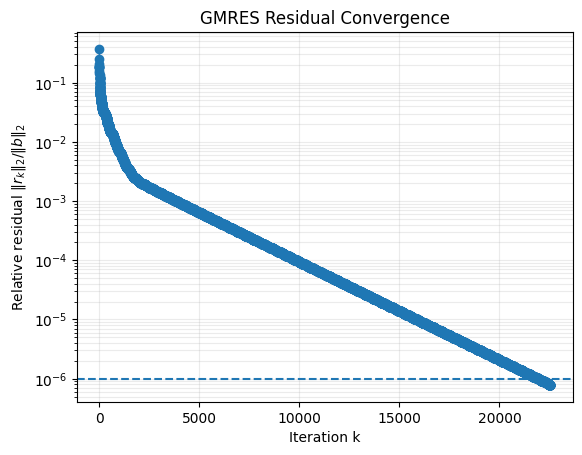

In [5]:
res_dir  = direct_solve(A, b)
res_gm   = gmres_solve(A, b, options=gmres_opts)
print("Direct ok:", res_dir.converged, "| GMRES iters:", len(res_gm.residuals))
_ = plot_residuals(res_gm, tol=gmres_opts.tol)


## Effect of PML (absorbing boundary)

With **PML off**, outgoing waves reflect at the boundary and interfere back into
the domain. With **PML on**, the outer layer damps energy so the interior field
looks more “open-domain”.

**Visual cues:**
- Without PML: standing-wave fringes hugging the outer boundary.
- With PML: reduced boundary amplitude, less artificial reflection.


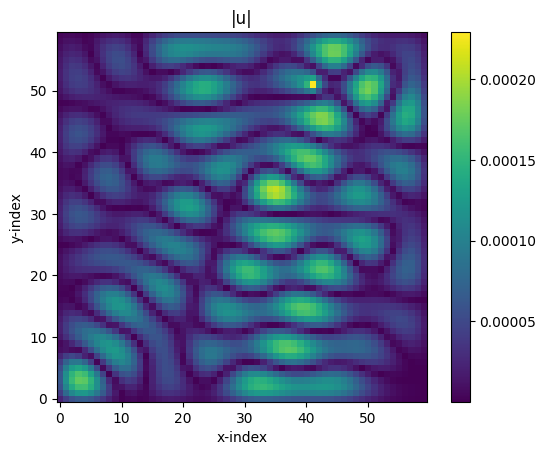

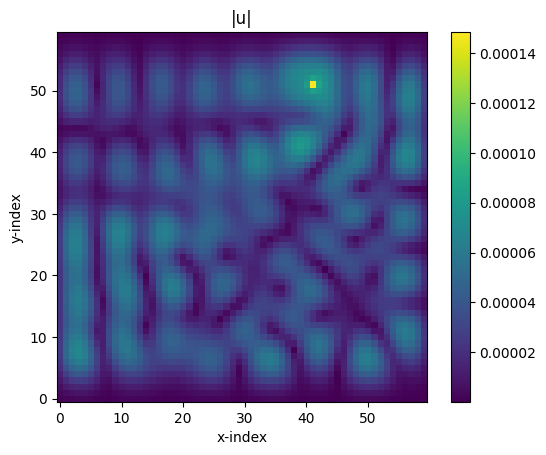

In [6]:
A0 = assemble_operator(grid=grid, k=k, kind="helmholtz")
A1 = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=PMLConfig())
u0 = direct_solve(A0, b).solution
u1 = direct_solve(A1, b).solution
_ = plot_field(u0, grid.shape, "magnitude")
_ = plot_field(u1, grid.shape, "magnitude")


## k-sweep: how wavenumber affects convergence

We fix the source and solve for multiple \(k\) values.

**Interpretation:**
- As \(k\) grows, the Helmholtz operator becomes more indefinite → GMRES
  typically needs **more iterations** (slower convergence).
- If iterations explode, consider:
  - relaxing `tol` temporarily (to explore)
  - using **PML** to suppress reflections
  - (future) adding a **preconditioner** (e.g., shifted Laplacian)


In [7]:
ks = [20, 24, 28, 32, 36]
def rhs_builder(g): return build_load(RandomPointSource(seed=0), g)
results = sweep_k(grid, ks, rhs_builder, solver_opts=gmres_opts)
[(k_, r.converged, len(r.residuals)) for k_, r in zip(ks, results)]


[(20, True, 1360),
 (24, True, 2567),
 (28, True, 9298),
 (32, True, 10240),
 (36, True, 38057)]

## Source-sweep: how the RHS impacts convergence

We keep \(k\) fixed and vary the **random point source** (amplitude/phase/location).
Different RHS realizations can change:
- how much energy lies in “hard” directions of \(A\)
- how quickly GMRES reduces the residual

If iteration counts vary widely across seeds, the system is sensitive to the
forcing — a useful signal for designing robust solvers/preconditioners.


In [8]:
seeds = [0,1,2,3,4]
results = sweep_sources(grid, seeds, k=k, solver_opts=gmres_opts)
[(s, r.converged, len(r.residuals)) for s, r in zip(seeds, results)]


[(0, True, 26045),
 (1, True, 24410),
 (2, True, 29183),
 (3, True, 20850),
 (4, True, 27110)]

## Saving results

We persist the complex solution field \(`npz`\) with shape metadata so it can be
reloaded later (e.g., for ML experiments or side-by-side comparisons):

```python
from src import save_field
save_field("data/results/02/field_u.npz", res.solution, grid.shape)


In [10]:
from src import load_field
U = load_field("data/results/02/field_u.npz")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\31624\\Documents\\MIT\\Programming\\FreqTransfer\\data\\results\\02\\field_u.npz'


---

### (If you keep the residual check cell)
```markdown
## Manual residual check

We compute \( \|A u - b\|_2 / \|b\|_2 \) directly to validate solver output.
This value should match the last GMRES residual (and be near `tol`) when
GMRES has converged. For LU, it verifies numerical accuracy of the factorization.
